In [1]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

DATA_DIR = '/kaggle/input/celebrities-100k/100k'
image_files = os.listdir(DATA_DIR)


In [3]:
print(os.listdir(DATA_DIR)[:10])
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

['100k']


In [4]:
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1                               
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores


In [5]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break


In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
train_dl = DeviceDataLoader(train_dl, device)

In [9]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

In [10]:
latent_size = 128

In [11]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)


In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)
generator = to_device(generator, device) # move generator to device

In [13]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



In [14]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

In [15]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
#  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

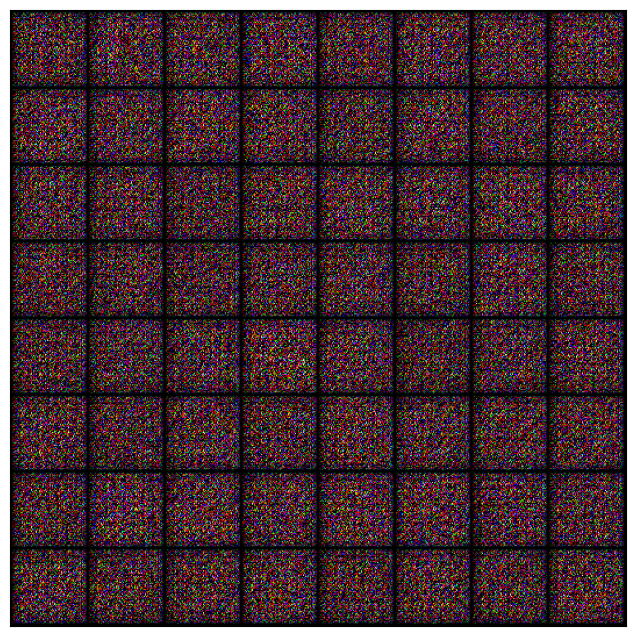

In [16]:

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [17]:
import os
import torch

checkpoint_path = 'checkpoint.pth'

def save_checkpoint(epoch, gen, disc, opt_gen, opt_disc, filename=checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'gen_state': gen.state_dict(),
        'disc_state': disc.state_dict(),
        'opt_gen_state': opt_gen.state_dict(),
        'opt_disc_state': opt_disc.state_dict()
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved at epoch {epoch}")

def load_checkpoint(filename=checkpoint_path):
    if os.path.exists(filename):
        checkpoint = torch.load(filename, map_location=device)
        generator.load_state_dict(checkpoint['gen_state'])
        discriminator.load_state_dict(checkpoint['disc_state'])

        opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

        opt_g.load_state_dict(checkpoint['opt_gen_state'])
        opt_d.load_state_dict(checkpoint['opt_disc_state'])

        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Checkpoint loaded, resuming from epoch {start_epoch}")
        return opt_g, opt_d, start_epoch
    else:
        print("🟡 No checkpoint found, starting from scratch")
        opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        return opt_g, opt_d, 0


In [18]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
def fit(epochs, lr, opt_g, opt_d, start_epoch=0):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(start_epoch, epochs):
        print(f"\n🌀 Epoch {epoch+1}/{epochs}")
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")

        save_samples(epoch+1, fixed_latent, show=False)

        # Save checkpoint each epoch
        save_checkpoint(epoch, generator, discriminator, opt_g, opt_d)

    return losses_g, losses_d, real_scores, fake_scores

In [19]:
# Hyperparameters
lr = 0.00025
epochs = 17

In [20]:
new_lr = 0.0003
opt_g, opt_d, start_epoch = load_checkpoint()
for param_group in opt_g.param_groups:
    param_group["lr"] = new_lr

for param_group in opt_d.param_groups:
    param_group["lr"] = new_lr
history = fit(epochs, new_lr, opt_g, opt_d, start_epoch=start_epoch)


🟡 No checkpoint found, starting from scratch

🌀 Epoch 1/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 3.0052, loss_d: 0.4792, real_score: 0.7176, fake_score: 0.0820
✅ Checkpoint saved at epoch 0

🌀 Epoch 2/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.9494, loss_d: 0.3570, real_score: 0.9156, fake_score: 0.2220
✅ Checkpoint saved at epoch 1

🌀 Epoch 3/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.3710, loss_d: 0.5106, real_score: 0.9372, fake_score: 0.3299
✅ Checkpoint saved at epoch 2

🌀 Epoch 4/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 7.2435, loss_d: 0.1754, real_score: 0.8569, fake_score: 0.0066
✅ Checkpoint saved at epoch 3

🌀 Epoch 5/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 2.3442, loss_d: 3.9713, real_score: 0.0289, fake_score: 0.0004
✅ Checkpoint saved at epoch 4

🌀 Epoch 6/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 5.3859, loss_d: 0.0552, real_score: 0.9863, fake_score: 0.0391
✅ Checkpoint saved at epoch 5

🌀 Epoch 7/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 2.6462, loss_d: 0.1768, real_score: 0.9156, fake_score: 0.0761
✅ Checkpoint saved at epoch 6

🌀 Epoch 8/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 1.4089, loss_d: 0.8597, real_score: 0.4804, fake_score: 0.0062
✅ Checkpoint saved at epoch 7

🌀 Epoch 9/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.5716, loss_d: 0.1118, real_score: 0.9816, fake_score: 0.0834
✅ Checkpoint saved at epoch 8

🌀 Epoch 10/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 3.2518, loss_d: 0.2680, real_score: 0.8121, fake_score: 0.0327
✅ Checkpoint saved at epoch 9

🌀 Epoch 11/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 5.8035, loss_d: 0.5935, real_score: 0.9816, fake_score: 0.3610
✅ Checkpoint saved at epoch 10

🌀 Epoch 12/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.6830, loss_d: 0.1251, real_score: 0.8977, fake_score: 0.0104
✅ Checkpoint saved at epoch 11

🌀 Epoch 13/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.1121, loss_d: 0.2778, real_score: 0.8920, fake_score: 0.1172
✅ Checkpoint saved at epoch 12

🌀 Epoch 14/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 2.4213, loss_d: 0.4159, real_score: 0.7397, fake_score: 0.0495
✅ Checkpoint saved at epoch 13

🌀 Epoch 15/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 6.1392, loss_d: 0.2647, real_score: 0.9943, fake_score: 0.2131
✅ Checkpoint saved at epoch 14

🌀 Epoch 16/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 5.2573, loss_d: 0.0593, real_score: 0.9724, fake_score: 0.0297
✅ Checkpoint saved at epoch 15

🌀 Epoch 17/17


  0%|          | 0/782 [00:00<?, ?it/s]

loss_g: 4.0831, loss_d: 0.0615, real_score: 0.9678, fake_score: 0.0270
✅ Checkpoint saved at epoch 16


In [21]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [22]:
losses_g, losses_d, real_scores, fake_scores = history

In [23]:
from IPython.display import Image


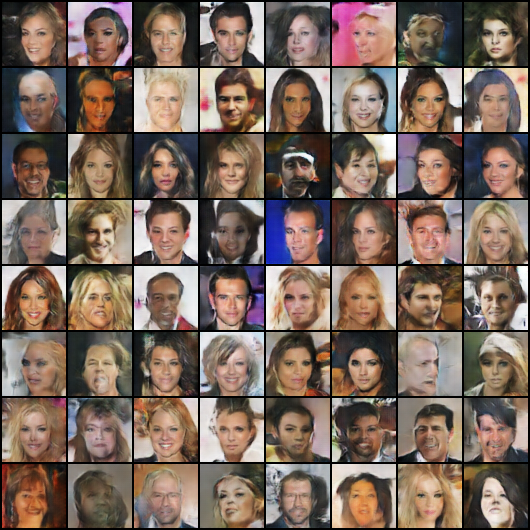

In [24]:
image_path = 'generated/generated=images-0017.png'

# Display the image
display(Image(filename=image_path))